In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys

sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv']


# Load data

In [2]:
%%time
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print(train.shape, test.shape)

(250, 302) (19750, 301)
CPU times: user 1.07 s, sys: 172 ms, total: 1.24 s
Wall time: 1.26 s


In [3]:
for c in train.columns:
    if c not in test.columns: print(c)

target


# Data analysis

In [4]:
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.000,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,...,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.000,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,...,0.971,-1.489,0.530,0.917,-0.094,-1.407,0.887,-0.104,-0.583,1.267,-1.667,-2.771,-0.516,1.312,0.491,0.932,2.064,0.422,1.215,2.012,0.043,-0.307,-0.059,1.121,1.333,0.211,1.753,0.053,1.274,-0.612,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.000,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,...,-0.540,-0.299,1.074,-0.748,1.086,-0.766,-0.931,0.432,1.345,-0.491,-1.602,-0.727,0.346,0.780,-0.527,-1.122,-0.208,-0.730,-0.302,2.535,-1.045,0.037,0.020,1.373,0.456,-0.277,1.381,1.843,0.749,0.202,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.000,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,...,-0.083,-0.831,1.251,-0.206,-0.933,-1.215,0.281,0.512,-0.424,0.769,0.223,-0.710,2.725,0.176,0.845,-1.226,1.527,-1.701,0.597,0.150,1.864,0.322,-0.214,1.282,0.408,-0.910,1.020,-0.299,-1.574,-1.618,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.000,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,...,-1.050,-0.347,0.904,-1.324,-0.849,3.432,0.222,0.416,0.174,-1.517,-0.337,0.055,-0.464,0.014,-1.073,0.325,-0.523,-0.692,0.190,-0.883,-1.830,1.408,2.319,1.704,-0.723,1.014,0.064,0.096,-0.775,1.845,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [5]:
null_cnt = train.isnull().sum().sort_values()
print('null count:', null_cnt[null_cnt > 0])

null count: Series([], dtype: int64)


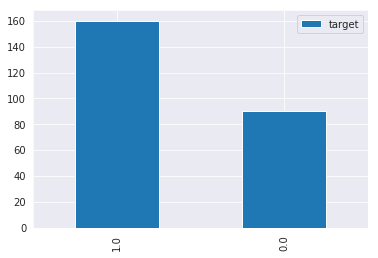

In [6]:
train['target'].value_counts().to_frame().plot.bar()

## feature selection

In [7]:
_='''
'''
from sklearn.datasets import load_boston
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

X = train.drop(['id','target'], axis=1)
y = train['target']
tr_ids = train['id']
te_ids = test['id']

rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', max_depth=5, random_state=42)
selector = RFE(rfc, n_features_to_select=200)
selector.fit(X, y)

selected = train.drop(['id','target'], axis=1).columns[selector.get_support()]
train = train[selected]
train['id'] = tr_ids
train['target'] = y
test = test[selected]
test['id'] = te_ids

# Prepare

In [8]:
all_data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

all_data.head()

,0,1,4,6,7,9,13,14,15,16,17,18,19,24,26,28,29,30,32,33,36,39,42,43,45,46,47,48,50,52,53,55,56,58,59,61,62,63,64,65,...,239,240,241,242,244,245,246,249,250,251,252,253,254,258,259,261,262,266,268,272,273,275,276,277,279,280,281,282,283,285,287,288,289,290,292,295,297,298,id,target
0,-0.098,2.165,1.309,-0.236,0.276,1.825,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,1.763,-1.097,-0.250,-1.859,1.125,-2.296,0.385,-0.144,0.005,-0.458,0.579,0.833,0.761,0.737,0.669,-1.542,-0.445,1.238,-1.891,-1.531,-0.927,2.072,-1.105,0.008,0.933,-1.410,-0.770,...,-0.181,0.723,-0.313,-0.165,0.074,-2.851,-1.021,0.218,-0.692,-0.514,0.754,-1.892,0.203,-0.516,-1.109,1.250,-0.565,-0.704,0.771,-1.516,-2.145,0.156,0.820,-1.049,0.484,0.617,1.253,1.248,0.504,-0.896,-0.284,-0.601,0.569,0.867,0.504,-2.097,-0.414,1.038,0,1.000
1,1.081,-0.973,-0.428,1.172,0.352,-0.291,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.519,-0.128,-0.540,1.238,-0.227,-0.390,-2.721,-0.121,-0.303,0.503,-1.320,-1.102,-0.947,0.267,0.695,0.188,-0.872,0.660,0.303,-0.553,0.588,0.472,-0.467,-0.064,1.808,0.633,1.221,...,0.366,-0.676,0.071,0.504,-1.160,-0.187,-0.430,1.307,-0.731,-1.234,0.960,1.470,0.652,0.630,1.158,-1.489,0.530,0.887,-0.583,-0.516,1.312,0.932,2.064,0.422,2.012,0.043,-0.307,-0.059,1.121,0.211,0.053,1.274,-0.612,-0.165,-1.257,-1.624,-1.099,-0.936,1,0.000
2,-0.523,-0.089,-0.022,-0.023,-0.172,0.183,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,1.786,-0.103,2.273,0.055,-2.032,0.064,0.924,-0.917,1.920,0.167,1.088,0.972,-1.554,0.218,-2.677,0.613,0.516,-0.714,-1.025,1.340,-0.071,0.552,0.847,-0.807,-0.091,1.424,0.943,...,-0.010,-0.815,1.000,-0.569,2.342,0.779,-0.548,2.165,-0.945,-2.269,0.678,0.468,-0.405,1.459,-0.511,-0.299,1.074,-0.931,1.345,0.346,0.780,-1.122,-0.208,-0.730,2.535,-1.045,0.037,0.020,1.373,-0.277,1.843,0.749,0.202,0.013,-1.222,-1.165,0.004,0.800,2,1.000
3,0.067,-0.021,-0.446,-1.035,0.834,0.274,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,0.365,-0.808,0.118,0.380,0.999,2.798,0.394,0.401,-2.241,0.009,0.423,-0.861,1.320,-0.976,-1.096,0.548,0.053,0.570,-0.717,-1.133,0.645,-1.083,-0.396,0.178,-0.421,0.196,-0.706,...,0.507,0.526,0.899,1.496,1.176,1.852,-0.001,0.027,0.795,-0.056,-0.497,0.814,-1.114,0.530,-0.528,-0.831,1.251,0.281,-0.424,2.725,0.176,-1.226,1.527,-1.701,0.150,1.864,0.322,-0.214,1.282,-0.910,-0.299,-1.574,-1.618,-0.404,-0.595,0.467,-0.254,-0.533,3,1.000
4,2.347,-0.831,1.225,0.585,1.509,2.198,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,0.024,1.656,-1.437,-0.581,-0.308,-1.739,0.037,2.371,-0.122,2.054,-0.318,0.344,0.161,0.830,-1.328,0.666,-1.016,-0.312,0.807,0.301,1.556,1.138,-0.755,-1.172,0.679,-0.787,0.357,...,0.024,-0.048,-0.693,-0.492,-0.233,-1.096,-0.728,1.490,-0.462,-0.767,-0.191,0.169,1.273,-0.906,0.348,-0.347,0.904,0.222,0.174,-0.464,0.014,0.325,-0.523,-0.692,-0.883,-1.830,1.408,2.319,1.704,1.014,0.096,-0.775,1.845,0.898,2.415,1.378,1.478,0.428,4,1.000


In [9]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: []


In [10]:
corr_matrix = all_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
del upper

drop_column = all_data.columns[to_drop]
print('drop columns:', drop_column)
#all_data.drop(drop_column, axis=1, inplace=True)

drop columns: Index([], dtype='object')


In [11]:
cols = [col for col in all_data.columns if col not in ['id','target']]
for i, t in all_data.loc[:, cols].dtypes.iteritems():
    if t == object:
        print(i)
        all_data[i] = pd.factorize(all_data[i])[0]

## scaling

In [12]:
from sklearn import preprocessing

numcols = all_data.drop(['id','target'],axis=1).select_dtypes(include='number').columns.values
#scaler = preprocessing.StandardScaler()
scaler = preprocessing.RobustScaler()
all_data.loc[:,numcols] = scaler.fit_transform(all_data[numcols])

## PCA

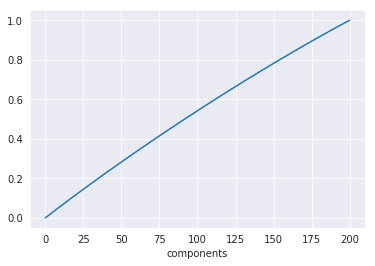

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(all_data[numcols])
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0,ev_ratio.cumsum()])

plt.xlabel('components')
plt.plot(ev_ratio)
plt.show()

# Feature engineering

In [14]:
X_train = all_data[all_data['target'].notnull()].reset_index(drop=True)
X_test = all_data[all_data['target'].isnull()].drop(['target'], axis=1).reset_index(drop=True)
del all_data
gc.collect()

# drop ID_code
X_train.drop(['id'], axis=1, inplace=True)
X_test_ID = X_test.pop('id')

Y_train = X_train.pop('target')

print(X_train.shape, X_test.shape)

(250, 200) (19750, 200)


### over sampling

In [15]:
_='''
from imblearn.over_sampling import SMOTE,ADASYN

#sm = SMOTE(random_state=42)
#sm = SMOTE(kind='svm',random_state=42)
#sm = SMOTE(kind='borderline1',random_state=42)
sm = ADASYN(random_state=42)
X_train, Y_train = sm.fit_sample(X_train, Y_train)
X_train = pd.DataFrame(X_train, columns=X_test.columns)
print(X_train.shape)
'''

### KMeans

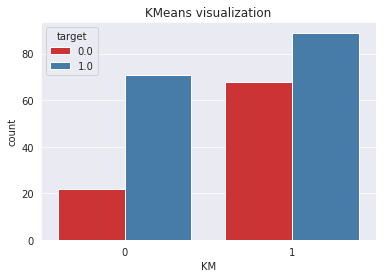

1    13719
0     6031
dtype: int64


In [16]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, random_state=42)
km.fit(X_train, Y_train)

X_train_km = km.predict(X_train)
X_test_km = km.predict(X_test)

km_data = pd.DataFrame({'KM':X_train_km, 'target':Y_train})
sns.countplot(x='KM', hue='target', palette='Set1', data=km_data)
plt.title('KMeans visualization')
plt.show()

print(pd.Series(X_test_km).value_counts())

In [17]:
X_train = pd.concat([X_train, pd.get_dummies(X_train_km, prefix='_km')], axis=1)
X_test = pd.concat([X_test, pd.get_dummies(X_test_km, prefix='_km')], axis=1)

### GaussianMixture

In [18]:
_='''
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, covariance_type='tied', random_state=42)
gm.fit(X_train, Y_train)

X_train_gm = gm.predict(X_train)
X_test_gm = gm.predict(X_test)

gm_data = pd.DataFrame({'GM':X_train_gm, 'target':Y_train})
sns.countplot(x='GM', hue='target', palette='Set1', data=gm_data)
plt.title('GaussianMixture visualization')
plt.show()

print(pd.Series(X_test_gm).value_counts())
'''

In [19]:
#X_train = pd.concat([X_train, pd.get_dummies(X_train_gm, prefix='_gm')], axis=1)
#X_test = pd.concat([X_test, pd.get_dummies(X_test_gm, prefix='_gm')], axis=1)

### KNeighborsClassifier

In [20]:
from sklearn.neighbors import KNeighborsClassifier

_='''
for k in range(2, 10):
    knc = KNeighborsClassifier(n_neighbors=k)
    knc.fit(X_train, Y_train)
    score = knc.score(X_train, Y_train)
    print("[%d] score: {:.2f}".format(score) % k)

knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X_train, Y_train)
X_train_knc = knc.predict(X_train)
X_test_knc = knc.predict(X_test)
knc_data = pd.DataFrame({'KNC':X_train_knc, 'target':Y_train})
sns.countplot(x='KNC', hue='target', palette='Set1', data=knc_data)
plt.title('KNeighborsClassifier visualization')
'''

In [21]:
#X_train['_knc'] = knc.predict_proba(X_train)[:,1]
#X_test['_knc'] = knc.predict_proba(X_test)[:,1]

# Predict

In [22]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV

In [23]:
splits = 10
folds = RepeatedStratifiedKFold(n_splits=splits, n_repeats=20, random_state=42)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    # add noise
    trn_x += np.random.normal(0, 0.01, trn_x.shape)

    '''
    clf = LogisticRegression(C=1, max_iter=3000, class_weight='balanced', 
            penalty='l1', solver='liblinear', random_state=42)
    model = RFECV(clf, step=1, cv=(splits - 1))
    model.fit(trn_x, trn_y)
    oof_preds[val_] = model.predict_proba(val_x)[:,1]
    sub_preds += model.predict_proba(X_test)[:,1] / splits / 20 #folds.n_splits
    '''
    clf = Lasso(alpha=0.03, tol=0.01, selection='random', random_state=42)
    model = RFECV(clf, step=1, cv=(splits - 1))
    model.fit(trn_x, trn_y)
    oof_preds[val_] = model.predict(val_x).clip(0, 1)
    sub_preds += model.predict(X_test).clip(0, 1) / splits / 20 #folds.n_splits
    #print('features:%d' % model.n_features_)

features:9
features:127
features:12
features:122
features:10
features:5
features:10
features:14
features:20
features:30
features:201
features:8
features:111
features:10
features:22
features:8
features:30
features:73
features:12
features:8
features:73
features:104
features:201
features:77
features:65
features:8
features:5
features:7
features:8
features:78
features:6
features:114
features:89
features:9
features:98
features:77
features:114
features:9
features:133
features:6
features:10
features:6
features:157
features:9
features:20
features:5
features:4
features:8
features:107
features:168
features:72
features:3
features:10
features:152
features:8
features:150
features:7
features:172
features:118
features:10
features:17
features:154
features:6
features:29
features:11
features:8
features:6
features:188
features:28
features:89
features:21
features:25
features:7
features:58
features:13
features:8
features:6
features:110
features:179
features:21
features:10
features:8
features:31
features:11


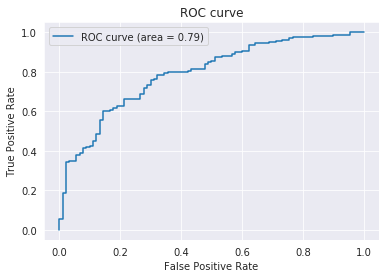

In [24]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# Submit

In [25]:
submission = pd.DataFrame({
    'id': X_test_ID,
    'target': sub_preds
})
submission.to_csv("submission.csv", index=False)

0.6528689595918544


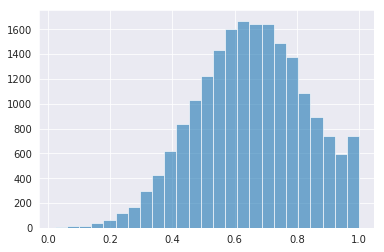

In [26]:
print(submission['target'].sum() / len(submission))
submission['target'].hist(bins=25, alpha=0.6)

In [27]:
submission.head()

,id,target
0,250,0.783
1,251,0.647
2,252,0.636
3,253,0.780
4,254,0.569
